# Learning curve analysis

Yangkang Chen<br>
Sep 5, 2023

In [2]:
import pandas as pd
import numpy as np
import random
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib
import warnings
import pickle
import os

# matplotlib.style.use('ggplot')
# plt.rcParams['axes.facecolor']='w'
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2


In [3]:
data = pd.read_csv(f'./stemy/dataset/test_data/Sample_data_Mallard.csv')


In [4]:
volume_list = [10000, 50000, 100000, 200000, 400000]

In [3]:
from stemflow.model.AdaSTEM import AdaSTEM, AdaSTEMClassifier, AdaSTEMRegressor
from xgboost import XGBClassifier, XGBRegressor
from stemflow.model.Hurdle import Hurdle_for_AdaSTEM, Hurdle

from stemflow.model_selection import ST_CV


In [ ]:
def get_X_and_y(data):
    X = data.drop('count', axis=1)
    y = data['count'].values
    return X, y

In [ ]:
all_metric_list = []

for volume in volume_list:
    if volume == 400000:
        tmp_data = data
    else:
        tmp_data = data.sample(volume, replace=False)
        
    # Get X and y
    X, y = get_X_and_y(tmp_data)
    
    # First thing first: Spatio-temporal train test split
    CV_generator = ST_CV(X, y,
                            Spatio_blocks_count = 50, Temporal_blocks_count=50,
                            CV=5)

    for cv_count, (X_train, X_test, y_train, y_test) in tqdm(enumerate(CV_generator), total=5):
        # 1. Train AdaSTEM hurdle model
        model = Hurdle_for_AdaSTEM(
            classifier=AdaSTEMClassifier(base_model=XGBClassifier(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1),
                                        save_gridding_plot = True,
                                        ensemble_fold=10, 
                                        min_ensemble_required=7,
                                        grid_len_lon_upper_threshold=25,
                                        grid_len_lon_lower_threshold=5,
                                        grid_len_lat_upper_threshold=25,
                                        grid_len_lat_lower_threshold=5,
                                        points_lower_threshold=50),
            regressor=AdaSTEMRegressor(base_model=XGBRegressor(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1),
                                        save_gridding_plot = True,
                                        ensemble_fold=10, 
                                        min_ensemble_required=7,
                                        grid_len_lon_upper_threshold=25,
                                        grid_len_lon_lower_threshold=5,
                                        grid_len_lat_upper_threshold=25,
                                        grid_len_lat_lower_threshold=5,
                                        points_lower_threshold=50)
        )
        
        ## fit adastem
        model.fit(X_train.reset_index(drop=True), y_train)
        
        # Evaluation
        pred_adastem = model.predict(X_test)
        perc = np.sum(np.isnan(pred_adastem.flatten()))/len(pred_adastem.flatten())
        print(f'AdaSTEM percentage not predictable {round(perc*100, 2)}%')

        # 2. Compare to simple Hurdle model
        model_SH = Hurdle(classifier=XGBClassifier(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1),
                regressor=XGBRegressor(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1))
        model_SH.fit(X_train[[i for i in X_train.columns if not i in ['longitude','latitude']]], y_train)
        pred_SH = model_SH.predict(X_test[[i for i in X_train.columns if not i in ['longitude','latitude']]])
        
        
        # 3. save metrics
        pred_df = pd.DataFrame({
            'y_true':y_test.flatten(),
            'y_pred_adastem':np.where(pred_adastem.flatten()<0, 0, pred_adastem.flatten()),
            'y_pred_SH':np.where(np.array(pred_SH).flatten()<0, 0, np.array(pred_SH).flatten())
        }).dropna() # to make sure that all points are both predicatble by adastem and simple hurdle model
        
        ## 3.1 adastem metrics
        metric_dict = AdaSTEM.eval_STEM_res('hurdle', pred_df.y_true, pred_df.y_pred_adastem)
        metric_dict['X_train_size'] = X_train.shape[0]
        metric_dict['CV'] = cv_count
        metric_dict['perc_not_predictable'] = perc
        metric_dict['model'] = 'AdaSTEM'
        metric_dict['Train_test_data_volume'] = volume
        all_metric_list.append(metric_dict.copy())
        
        ## 3.2 simple hurdle metrics
        metric_dict = AdaSTEM.eval_STEM_res('hurdle', np.array(pred_df.y_true).flatten(), 
                                            np.where(
                                                np.array(pred_df.y_pred_SH).flatten()<0,
                                                0,
                                                np.array(pred_df.y_pred_SH).flatten()
                                                )
                                            )
        metric_dict['X_train_size'] = X_train.shape[0]
        metric_dict['CV'] = cv_count
        metric_dict['perc_not_predictable'] = np.nan
        metric_dict['model'] = 'XGBoostHurdle'
        metric_dict['Train_test_data_volume'] = volume
        all_metric_list.append(metric_dict.copy())
        
    
    

In [24]:
all_metric_df = pd.DataFrame(all_metric_list)
all_metric_df.to_csv('./test_output/Learning_curve.csv',index=False)

## Plot learning curve metrics

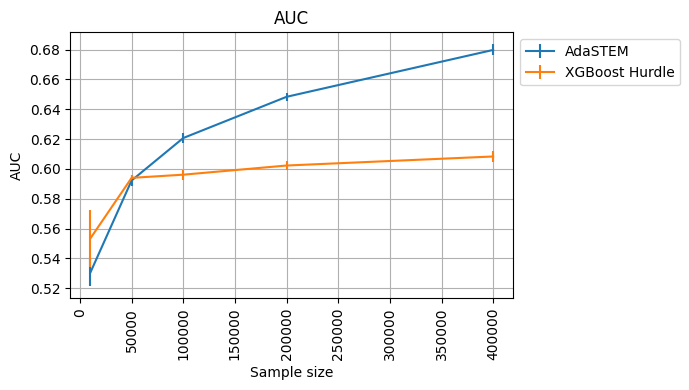

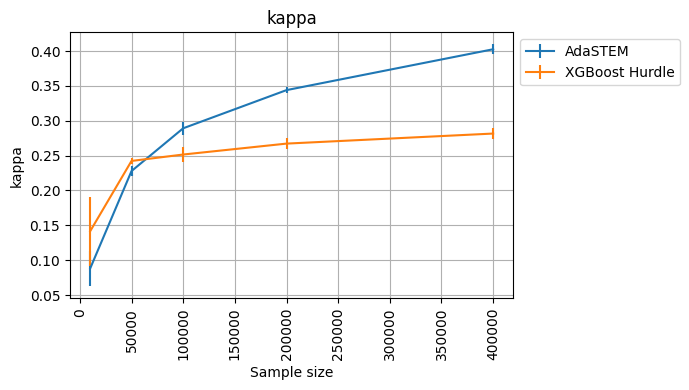

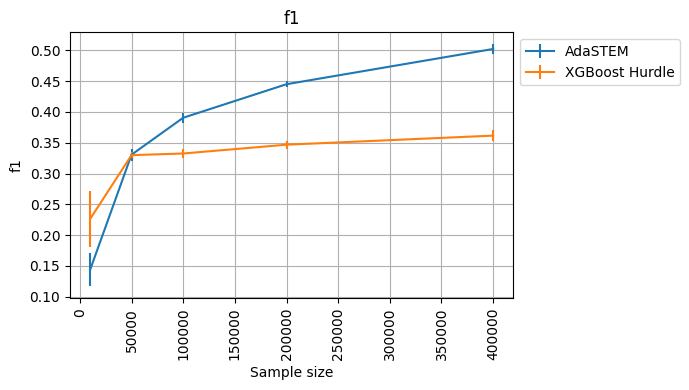

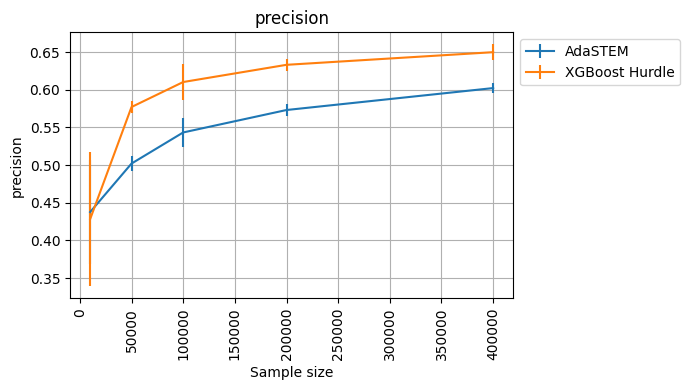

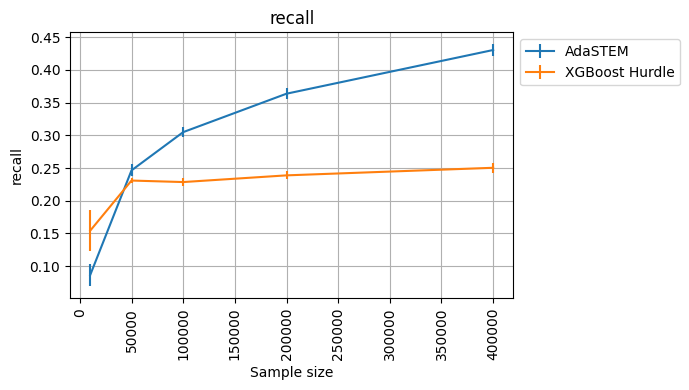

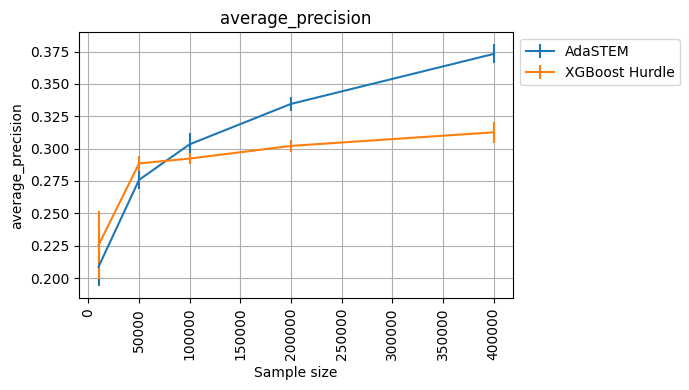

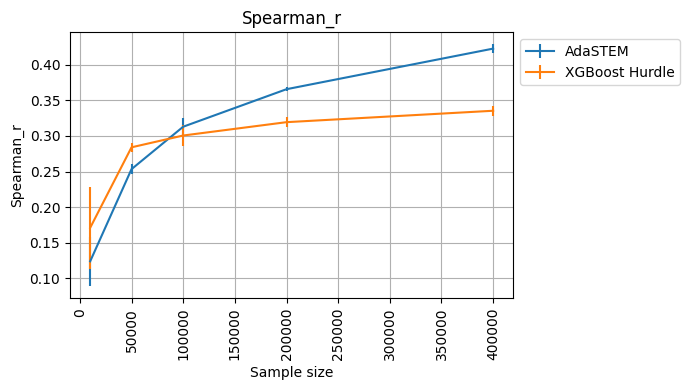

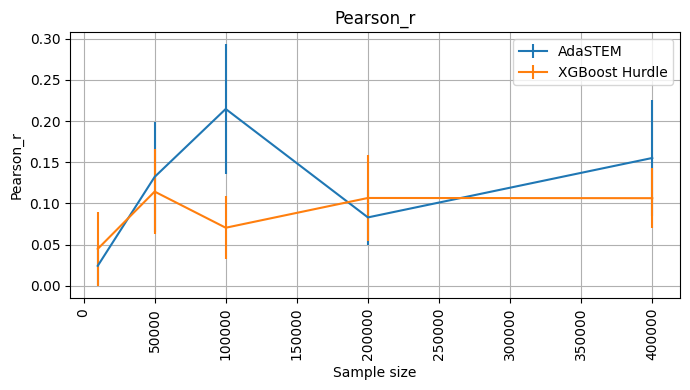

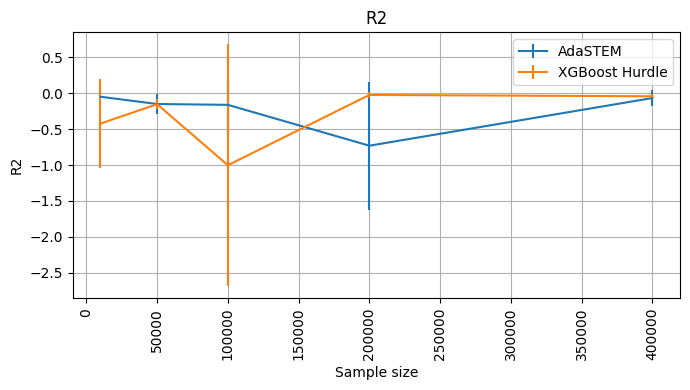

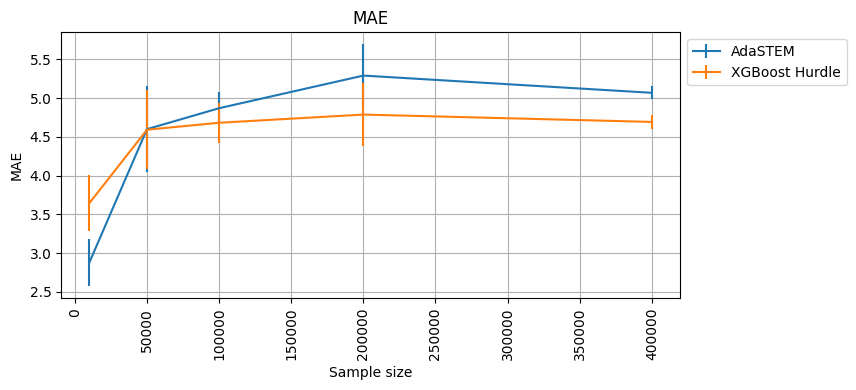

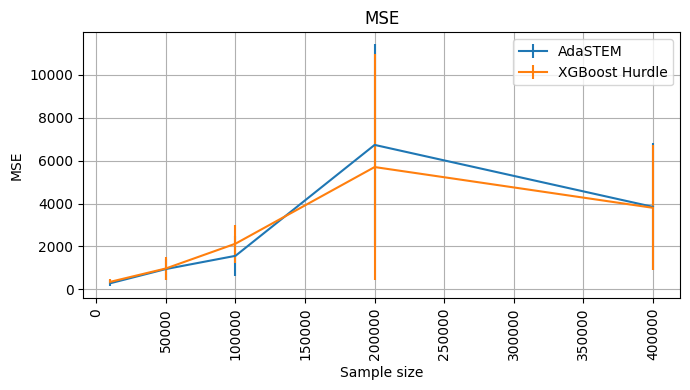

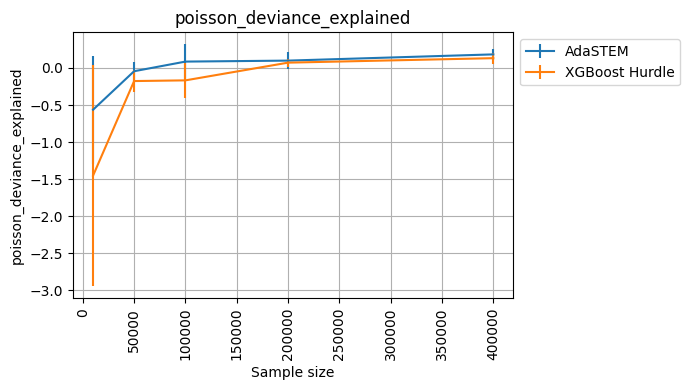

In [31]:
for var_ in ['AUC', 'kappa', 'f1', 'precision', 'recall', 'average_precision',
       'Spearman_r', 'Pearson_r', 'R2', 'MAE', 'MSE',
       'poisson_deviance_explained']:
    plt.figure(figsize=(7,4))
    
    sub = all_metric_df[all_metric_df.model=='AdaSTEM']
    plt.errorbar(
        x=sub.groupby('Train_test_data_volume').first().index,
        y=sub.groupby('Train_test_data_volume')[var_].mean(),
        yerr=sub.groupby('Train_test_data_volume')[var_].std(),
        label = 'AdaSTEM'
    )

    sub = all_metric_df[all_metric_df.model=='XGBoostHurdle']
    plt.errorbar(
        x=sub.groupby('Train_test_data_volume').first().index,
        y=sub.groupby('Train_test_data_volume')[var_].mean(),
        yerr=sub.groupby('Train_test_data_volume')[var_].std(),
        label='XGBoost Hurdle'
    )

    plt.legend(bbox_to_anchor=(1,1))
    plt.grid()
    plt.title(var_)
    plt.xlabel('Sample size')
    plt.ylabel(f'{var_}')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(f'./test_output/comparing_AdaSTEM_and_Hurdle_{var_}.pdf')
    plt.show()



In [4]:
%load_ext watermark
%watermark -n -u -v -iv -w

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Wed Sep 06 2023

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 8.14.0

matplotlib: 3.7.1
numpy     : 1.24.3
pandas    : 2.0.3

Watermark: 2.3.1

